## Analysing performance of Rocket based classifier 

In [1]:
import sys

sys.path.insert(0, "..")

from joblib import Parallel, delayed

import scipy.io
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import matplotlib.pyplot as plt

from HAR.transformers import CSIMinMaxScaler, Rocket
from HAR.classifiers import RidgeVotingClassifier


def load_dataset(infile):
    mat = scipy.io.loadmat(infile)
    X = mat["csi"].T
    nsamples = mat["nsamples"].flatten()
    dim = mat["dim"].flatten()
    classnames = list(map(lambda s: s.strip().title(), mat["classnames"]))
    y = []
    for i in range(len(classnames)):
        y += [i] * nsamples[i]
    y = np.array(y)
    return X, y, nsamples, classnames, dim


class RidgeVotingClassifierExt(RidgeVotingClassifier):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

    def predict(self, X):
        n_samples, n_sc, *_ = X.shape
        final_predictions = np.zeros((n_samples,))
        disagree_sc = []
        for isample in range(n_samples):
            predictions = Parallel(n_jobs=1, backend="threading")(
                delayed(self._score)(
                    self._models[m_], np.expand_dims(X[isample, m_, :], axis=0)
                )
                for m_ in range(n_sc)
            )

            predictions = np.array(predictions)
            unique, counts = np.unique(predictions, return_counts=True)
            best = unique[np.argmax(counts)]
            final_predictions[isample] = best

            disagree_sc.extend(list(np.where(predictions != best)))

        return final_predictions, disagree_sc


pipe = Pipeline(
    [
        ("scaler", CSIMinMaxScaler()),
        (
            "feature_selector",
            Rocket(n_kernels=2500),
        ),
        (
            "classifier",
            RidgeVotingClassifierExt(n_classes=3),
        ),
    ]
)

In [2]:
X, y, nsamples, classnames, dim = load_dataset("../dataset/rCSI-3")
X = X.reshape(X.shape[0], *dim)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y)

pipe.fit_transform(X_train, y_train)

y_pred, disagree_sc = pipe.predict(X_test)

print(f"\n> Test Accuracy: {accuracy_score(y_test, y_pred)*100:.4f}%")
print("\n> Confusion Matrix: ")
print(confusion_matrix(y_test, y_pred))
print("\n> Classification Report :")
print(classification_report(y_test, y_pred, target_names=classnames))

100%|██████████| 300/300 [00:39<00:00,  7.55it/s]



> Test Accuracy: 96.6667%

> Confusion Matrix: 
[[ 97   0   3]
 [  0 100   0]
 [  1   6  93]]

> Classification Report :
              precision    recall  f1-score   support

       Empty       0.99      0.97      0.98       100
        Walk       0.94      1.00      0.97       100
        Jump       0.97      0.93      0.95       100

    accuracy                           0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300



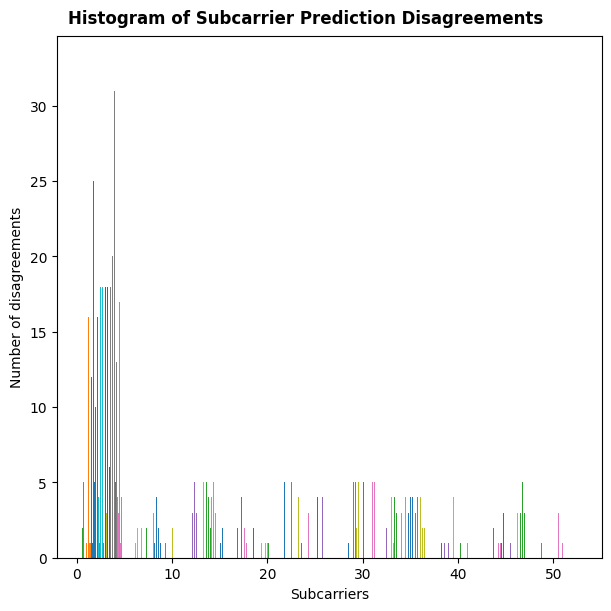

In [4]:
plt.figure(figsize=(6, 6), constrained_layout=True)
plt.hist(disagree_sc)
plt.xlabel("Subcarriers")
plt.ylabel("Number of disagreements")
plt.suptitle("Histogram of Subcarrier Prediction Disagreements", fontweight="bold")
plt.show()

In [5]:
import warnings

warnings.filterwarnings("ignore")

X, y, nsamples, classnames, dim = load_dataset("../dataset/rCSI-4")
X = X.reshape(X.shape[0], *dim)

y_pred, disagree_sc = pipe.predict(X)

print(f"\n> Test Accuracy: {accuracy_score(y, y_pred)*100:.4f}%")
print("\n> Confusion Matrix: ")
print(confusion_matrix(y, y_pred))
print("\n> Classification Report :")
print(classification_report(y, y_pred, target_names=classnames))

100%|██████████| 360/360 [00:41<00:00,  8.76it/s]



> Test Accuracy: 91.1111%

> Confusion Matrix: 
[[ 98   0  22]
 [  0 113   7]
 [  0   3 117]]

> Classification Report :
              precision    recall  f1-score   support

       Empty       1.00      0.82      0.90       120
        Walk       0.97      0.94      0.96       120
        Jump       0.80      0.97      0.88       120

    accuracy                           0.91       360
   macro avg       0.93      0.91      0.91       360
weighted avg       0.93      0.91      0.91       360



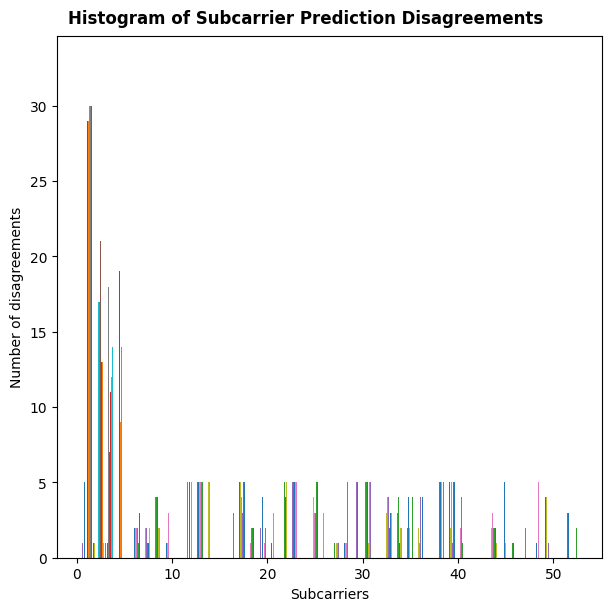

In [7]:
plt.figure(figsize=(6, 6), constrained_layout=True)
plt.hist(disagree_sc)
plt.xlabel("Subcarriers")
plt.ylabel("Number of disagreements")
plt.suptitle("Histogram of Subcarrier Prediction Disagreements", fontweight="bold")
plt.show()